In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pandas as pd
import seaborn as sns
import cmocean.cm as cmo
from glob import glob
import datetime

%matplotlib inline

## load sydney airport rainfall data and PH100 salinity

In [2]:
# load Sydney airport rainfall data
BOM = pd.read_csv('../data/IDCJAC0009_066037_1800_Data_Jan23.csv')
# construct time index
BOM['TIME']=pd.to_datetime(BOM[['Year', 'Month', 'Day']])
# rename column to the shorter 'rain'
BOM.rename({'Bureau of Meteorology station number': 'station',
            'Rainfall amount (millimetres)': 'rain'}, axis=1, inplace=True)
#Set time index
BOM = BOM.set_index(pd.DatetimeIndex(BOM['TIME']).date)
BOM.index = pd.to_datetime(BOM.index)
# add day of year column
BOM['DOY'] = BOM['TIME'].dt.dayofyear
# remove 1929
BOM = BOM['1930':'2022']

# convert back to xarray
rain = xr.DataArray(data=BOM.rain, dims=["TIME"], coords=[BOM.TIME])
rain=rain.sel(TIME=slice('2008','2022'))

# load PH100 salinity
nc = xr.open_dataset('../data/IMOS_ANMN-NSW_SZ_20100504_PH100_FV01_PSAL-aggregated-timeseries_END-20230316_C-20230520.nc')

# load Salinity climatology
clim = xr.open_dataset('../data/PH100_PSAL_2008-2023_Mooring_climatology_v1.nc')

### clean up mooring salinity data and put in pandas dataframe

In [3]:
df = pd.DataFrame({'TIME': nc.TIME,
                   'PSAL': nc.PSAL, 
                   'PSALqc': nc.PSAL_quality_control,
                   'DEPTH' : nc.DEPTH,
                   'DEPTHqc' : nc.DEPTH_quality_control}
                 ).set_index('TIME')
# add day of year column
df['TIME'] = df.index
df['DOY'] = df['TIME'].index.dayofyear
df['Year'] = df['TIME'].index.year

# apply QC flags for good data only
df_good = df[(df.PSALqc == 1) & (df.DEPTHqc ==1)]
# get data from top CTD only

PSAL_surf = df_good[(df_good.DEPTH<40)].resample('1D').mean()
PSAL_surf.index = pd.to_datetime(PSAL_surf.index)

/var/folders/g0/w24709ld71b5r2ln5v1rzt6c0000gq/T/ipykernel_42350/2870967813.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  PSAL_surf = df_good[(df_good.DEPTH<40)].resample('1D').mean()


## Load glider data (to get start and end dates of each mission when it enters Hawkesbury shelf)

In [4]:
filelist=[]
for files in glob('../data/Gliders/*.nc'): 
    #print(files)
    filelist.append(files)
    filelist.sort()

#remove irrelevant missions that go too far offshore or large rainfall events
# indexes =[1,2,4,5,8,9,10,11,12,13,14,23,24,39,40]
# for index in sorted(indexes, reverse=True):
#     del filelist[index]
missions=[]
for glid in range(0,len(filelist)):
    Gdr = xr.open_dataset(filelist[glid])
    missions.append(Gdr)
    
Gdr = xr.concat(missions, dim = 'mission')
Gdr = Gdr.where((Gdr.dive_lat<-31.5) & (Gdr.dive_lat>-34) & (Gdr.bathydepth>-200),drop=True)

### Indexes of 'wet' and normal ('dry') glider missions

In [5]:
wet_missions = [12,31,36,40]
dry_missions = [0,1,3,4,8,9,11,13,14,15,16,18,19,20,21,22,23,24,25,27,28,29,30,32,33,34,35,37,38,41]

## Put rainfall and salinity into pivot table to plot annual cumulative sums

In [6]:
piv = pd.pivot_table(BOM,index=['DOY'],columns=['Year'], values=['rain'])
piv_salt = pd.pivot_table(PSAL_surf,index=['DOY'],columns=['Year'], values=['PSAL'])
cl = clim.PSAL_PER5.to_pandas()

# Plot

/var/folders/g0/w24709ld71b5r2ln5v1rzt6c0000gq/T/ipykernel_42350/4022257166.py:20: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(BOM['2015'].DOY,BOM['2015'].rain.cumsum(),color='tab:brown',linewidth=3,label='2015')
/var/folders/g0/w24709ld71b5r2ln5v1rzt6c0000gq/T/ipykernel_42350/4022257166.py:21: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(BOM['2018'].DOY,BOM['2018'].rain.cumsum(),color='tab:orange',linewidth=3,label='2018')
/var/folders/g0/w24709ld71b5r2ln5v1rzt6c0000gq/T/ipykernel_42350/4022257166.py:22: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is de

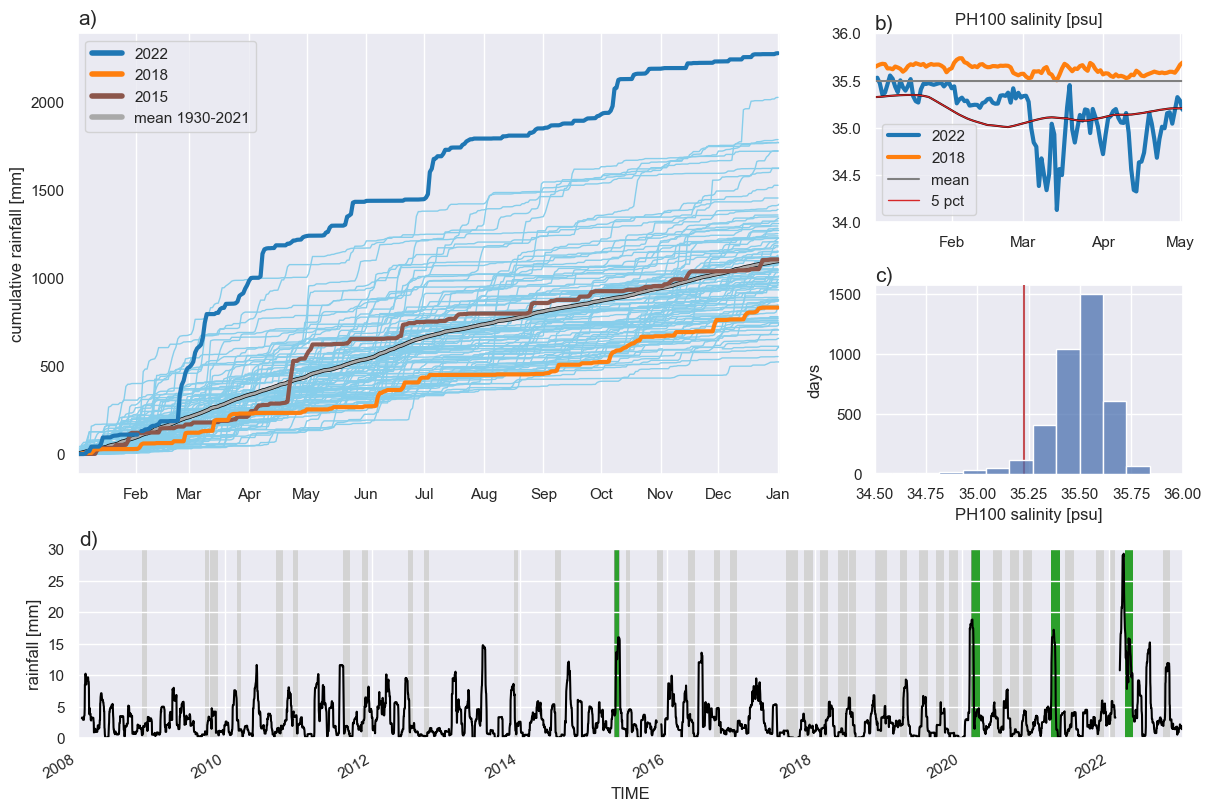

In [9]:
sns.set_theme()

# make custom legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='tab:blue', lw=4),
                Line2D([0], [0], color='tab:orange', lw=4),
                Line2D([0], [0], color='tab:brown', lw=4),
                Line2D([0], [0], color='darkgrey', lw=4)]



fig = plt.figure(figsize=(12, 8), constrained_layout=True)
spec = fig.add_gridspec(ncols=3, nrows=3)

# Plot rain
ax0 = fig.add_subplot(spec[:-1, :-1])
piv.cumsum().plot(legend=False,color='skyblue',linewidth=1, ax=ax0)
piv.mean(axis=1).cumsum().plot(color='black',linewidth=3)
piv.mean(axis=1).cumsum().plot(color='darkgrey',linewidth=2,label='mean 1930-2021')
plt.plot(BOM['2015'].DOY,BOM['2015'].rain.cumsum(),color='tab:brown',linewidth=3,label='2015')
plt.plot(BOM['2018'].DOY,BOM['2018'].rain.cumsum(),color='tab:orange',linewidth=3,label='2018')
plt.plot(BOM['2022'].DOY,BOM['2022'].rain.cumsum(),color='tab:blue',linewidth=3,label='2022')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(DateFormatter("%b"))
plt.grid(axis='y')
plt.xlabel('')
plt.ylabel('cumulative rainfall [mm]')
plt.xlim(BOM.DOY.min(),BOM.DOY.max())
ax0.legend(custom_lines, ['2022', '2018','2015', 'mean 1930-2021'])
ax0.text(.001, 1.02, 'a)',transform=ax0.transAxes, fontsize=15)

# Plot PH100 salinity
ax1 = fig.add_subplot(spec[0, 2])
plt.plot(PSAL_surf['2022-01-01':'2022-05-01'].DOY,PSAL_surf['2022-01-01':'2022-05-01'].PSAL
         ,color='tab:blue',linewidth=3,label='2022')
plt.plot(PSAL_surf['2018-01-01':'2018-05-01'].DOY,PSAL_surf['2018-01-01':'2018-05-01'].PSAL
         ,color='tab:orange',linewidth=3,label='2018')
# plt.axhline(35.224,label='5th pct', color='red')
plt.axhline(PSAL_surf.PSAL.mean(),label='mean', color='grey')
# plt.axhspan(35.16, 35.26,alpha=.2,color='red')
plt.plot(PSAL_surf['2022-01-01':'2022-05-01'].DOY,clim.PSAL_PER5.sel(TIME=slice('2009-01-01','2009-05-01')).squeeze()
         ,color='black',linewidth=1.5)
plt.plot(PSAL_surf['2022-01-01':'2022-05-01'].DOY,clim.PSAL_PER5.sel(TIME=slice('2009-01-01','2009-05-01')).squeeze()
         ,color='tab:red',linewidth=1,label='5 pct')

plt.ylim(34,36)
plt.xlim(PSAL_surf['2022-01-01':'2022-05-01'].DOY.min(),PSAL_surf['2022-01-01':'2022-05-01'].DOY.max())
plt.title ('PH100 salinity [psu]')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(DateFormatter("%b"))
plt.xlabel('')


#plt.gca().xaxis.set_ticklabels([])
plt.legend()
ax1.text(.001, 1.02, 'b)',transform=ax1.transAxes, fontsize=15)


#plot PH100 salinity histogram
ax2 = fig.add_subplot(spec[1, 2])
plt.axvline(x=35.229,color='r',zorder=5)
#plt.axvspan(35.16, 35.26,alpha=.2,color='red')
sns.histplot(data=PSAL_surf, x="PSAL",bins=15,zorder=10)
plt.xlabel('PH100 salinity [psu]')
plt.ylabel('days')
plt.xlim(34.5,36)
ax2.text(.001, 1.02, 'c)',transform=ax2.transAxes, fontsize=15)


ax3 = fig.add_subplot(spec[2,:])
rain.rolling(TIME=21).mean().plot(color='black')
plt.ylabel('rainfall [mm]')
plt.ylim(0,30)
#rain_N.rolling(TIME=21).mean().plot(color='grey')
for i in range(0,len(Gdr.mission)):
    plt.vlines(Gdr.sel(mission=i).dive_time.values,0,30,color='lightgray',alpha=.3,zorder=0) 
plt.grid

for i in wet_missions:
    plt.vlines(Gdr.sel(mission=i).dive_time.values,0,30,color='tab:green',alpha=.1,zorder=0) 
    
ax3.text(.001, 1.02, 'd)',transform=ax3.transAxes, fontsize=15)
ax3.set_xlim([datetime.date(2008, 1, 1), datetime.date(2022, 12, 31)])

#plt.savefig("Fig_2.eps", format='eps', bbox_inches='tight')